In [4]:
from IPython.core.display import display, HTML
import pandas as pd
import numpy as np
import os
import re
import json
import presto  # import prestosql python client
import psycopg2
import warnings

import altair as alt
from altair import datum
from requests.packages.urllib3.exceptions import InsecureRequestWarning
import datetime
warnings.simplefilter('ignore', InsecureRequestWarning)

import scipy.stats as stats
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None
pd.options.display.max_rows = 100
alt.data_transformers.disable_max_rows()
uid = "_svc_acs_presto"
pwd = "em6qF7Gp8E9ECYcKx3gHZ#v$H@pzT7AX3uCJp%5wesKE%VD6gZaCB8*rZ2zNgMKdPkuetSJph2H&H2eadbfCkeB3tBbUqcM^Sj5k"

conn = presto.dbapi.connect(host='acs-exports.bi.ghdna.io',
                            port=8446,
                            user='_svc_acs_presto',
                            catalog='hive',
                            schema='default',
                            http_scheme='https',
                            verify=False,
                            auth=presto.auth.BasicAuthentication(uid, pwd))
cur = conn.cursor()


def get_conn(db):
    conn = psycopg2.connect(db)
    return conn


def get_cursor(conn):
    cursor = conn.cursor()
    return cursor


def statement_to_df(cursor):
    df = pd.DataFrame(cursor.fetchall(), columns=[i[0] for i in cursor.description])
    return df


prod = f"host='ghdb-prod.bi.ghdna.io' dbname='ghdb' user='scientist' password='gh-scientist-rocks!'"

GHDB_prod_conn = get_conn(prod)
GHDB_prod_cursor = get_cursor(GHDB_prod_conn)
pd.options.display.max_rows = 4000

### Read into the comprehensive G360 dataset

In [5]:
g360_data = pd.read_csv('/ghds/projects/labdesk/jiwang/proactive_monitoring/acs_exports/g360_reagent_instrument_qc_metric.csv')

/home/jiwang/miniconda3/envs/my_environment/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (5,6,7,8,9,10,14,18,20,23,24,25,26,27,28,29,30,31,32,33,34,35,92) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
g360_data.head()

,acs_instance,batch_name,stage,operation_name,created_YYMMDD,Re_enrich_YYMMDD,Re_pooling_YYMMDD,Ori_pooling_YYMMDD,is_repeat,is_rerun,is_final,variable,value,batch_no,run_sample_id,total_yield,latest_molarity_EN,original_molarity_EN,ex_row,ex_column,en_row,en_column,molarity_EN,project,sample_type,gender,runid,flowcell_id,connection_id,NextSeq,NextSeq_Buffer_Cartridge,NextSeq_Reagent_Cartridge,NextSeq_Flowcell_Cartridge,seq_run_date,seq_YYMM,seq_YYMMDD,flowcell_aio_controls,flowcell_autoqc_total,flowcell_cluster_density,flowcell_cluster_density_max,flowcell_clusters_passing_filter,flowcell_phasing_1,flowcell_phasing_2,flowcell_phasing_index,flowcell_prephasing_1,flowcell_prephasing_2,flowcell_prephasing_index,flowcell_qscore_1,flowcell_qscore_2,flowcell_qscore_index,aiocontrol_false_positive_cnv,aiocontrol_false_positive_fusion,aiocontrol_false_positive_indel,aiocontrol_false_positive_msi,aiocontrol_false_positive_snv,aiocontrol_sensitivity_cnv,aiocontrol_sensitivity_fusion,aiocontrol_sensitivity_indel,aiocontrol_sensitivity_msi,aiocontrol_sensitivity_snv,num_germline_brca_biallelic,pathogenic_germline_num,sample_autoqc_total,sample_contamination_pct,sample_coverage_exceptions,sample_dectree_raises_max_som_maf,sample_distbin_raises_max_som_maf,sample_distbin_vs_dectree,sample_female_chry_molecules,sample_fusions_with_two_molecules,sample_gc_bias,sample_gender_status_mismatch,sample_germline_contamination,sample_germline_variance,sample_missing_mut_aa,sample_multiple_complex_indel,sample_multiple_low_fd,sample_non_singleton_families,sample_on_target_rate,sample_pval_vs_distbin,sample_single_molecule_indel,sample_somatic_max_pct,sample_suppressed_onesnp_upper,sample_too_many_fusion_genes,sample_too_many_fusions,sample_whitelist_germline_distbin,sample_whitelist_germline_pval,diversity,day_diff,lp_input,norm_en,conversion_rate,ex_bin
0,acs_default_clia,CLIA-1090,Extraction,Prepare Extraction Reagents,2020-01-24,2020-01-27,2020-01-28,2020-01-27,False,False,True,QIASymphony_Circulating_DNA_Kit,163037647,1090.0,A022891201,43.19,9.04,3.01,B,1.0,B,1.0,3.01,GHI_01,Clinical,Female,200127_NB551240_0313_AHG5M7BGXC,HG5M7BGXC,Flowcell ID A,NSQ00014,20404513.0,20383557.0,20383185.0,2020-01-27 00:00:00,2020-01,2020-01-27,1.0,23.0,207750.0,NaN,89.3,0.001,0.0013,0.0,0.0005,0.0007,0.0,92.0,89.74,95.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,30.0,0.01,233.0,NaN,NaN,NaN,0.0,NaN,372.67,0.0,0.0,NaN,NaN,NaN,NaN,1208.0,90.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1960.0,-1.0,30.0,0.100333,0.217778,>30
1,acs_default_clia,CLIA-1090,Extraction,QIASymphony Extraction,2020-01-24,2020-01-27,2020-01-28,2020-01-27,False,False,True,PBS_with_EDTA_1x,P020302G1901,1090.0,A022891201,43.19,9.04,3.01,B,1.0,B,1.0,3.01,GHI_01,Clinical,Female,200127_NB551240_0313_AHG5M7BGXC,HG5M7BGXC,Flowcell ID A,NSQ00014,20404513.0,20383557.0,20383185.0,2020-01-27 00:00:00,2020-01,2020-01-27,1.0,23.0,207750.0,NaN,89.3,0.001,0.0013,0.0,0.0005,0.0007,0.0,92.0,89.74,95.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,30.0,0.01,233.0,NaN,NaN,NaN,0.0,NaN,372.67,0.0,0.0,NaN,NaN,NaN,NaN,1208.0,90.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1960.0,-1.0,30.0,0.100333,0.217778,>30
2,acs_default_clia,CLIA-1090,Extraction,QIASymphony Extraction,2020-01-24,2020-01-27,2020-01-28,2020-01-27,False,False,True,QIASymphony,QSY00004,1090.0,A022891201,43.19,9.04,3.01,B,1.0,B,1.0,3.01,GHI_01,Clinical,Female,200127_NB551240_0313_AHG5M7BGXC,HG5M7BGXC,Flowcell ID A,NSQ00014,20404513.0,20383557.0,20383185.0,2020-01-27 00:00:00,2020-01,2020-01-27,1.0,23.0,207750.0,NaN,89.3,0.001,0.0013,0.0,0.0005,0.0007,0.0,92.0,89.74,95.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,30.0,0.01,233.0,NaN,NaN,NaN,0.0,NaN,372.67,0.0,0.0,NaN,NaN,NaN,NaN,1208.0,90.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1960.0,-1.0,30.0,0.100333,0.217778,>30
3,acs_default_clia,CLIA-1090,Extraction,Prepare Tapestation EX,2020-01-24,2020-01-27,2020-01-28,2020-01-27,False,False,True,SPK2,000000258,1090.0,A022891201,43.19,9.04,3.01,B,1.0,B,1.0,3.01,GHI_01,Cli

### Check the EN Molarity performance of ENW or ENC STA

In [10]:
g360_data_sub_sta = g360_data[ (g360_data.acs_instance == 'acs_default_clia' ) & (g360_data.variable.isin(['ENC_STAR', 'ENW_STAR']) ) &  (g360_data.created_YYMMDD >= '2024-04-11') &  (g360_data.created_YYMMDD >= '2024-04-25')  & (~g360_data.molarity_EN.isnull()) & (~g360_data.ex_bin.isnull())] [['acs_instance','batch_name', 'created_YYMMDD', 'value', 'run_sample_id', 'en_row','en_column','molarity_EN', 'norm_en']].drop_duplicates()
g360_data_sub_sta['EN_status'] = g360_data_sub_sta['molarity_EN'].apply(lambda x: 'FAIL' if x < 0.35 or x > 130 else 'PASS' )
g360_data_sub_sta.head()

,acs_instance,batch_name,created_YYMMDD,value,run_sample_id,en_row,en_column,molarity_EN,norm_en,EN_status
486878,acs_default_clia,CLIA-8467,2024-04-26,STA00001,B00631794,B,1.0,7.70,0.298913,PASS
486923,acs_default_clia,CLIA-8467,2024-04-26,STA00001,A101632501,C,1.0,4.67,0.617725,PASS
486968,acs_default_clia,CLIA-8467,2024-04-26,STA00001,A102327501,D,1.0,7.00,0.434783,PASS
487013,acs_default_clia,CLIA-8467,2024-04-26,STA00001,A102405501,E,1.0,3.31,0.569707,PASS
487058,acs_default_clia,CLIA-8467,2024-04-26,STA00001,A102430601,F,1.0,4.99,0.531983,PASS


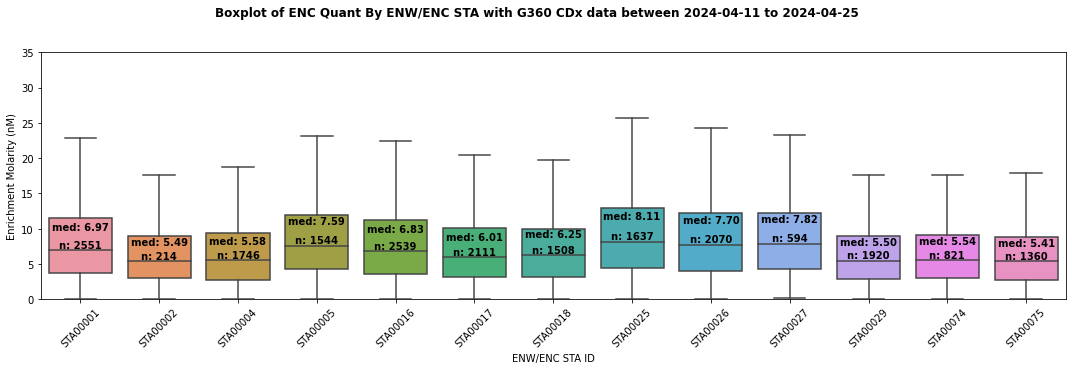

In [11]:
f, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=g360_data_sub_sta.sort_values(by = ['value']), x="value", y="molarity_EN",  showfliers=False)
plt.ylim(0, 35) 
ax.set_xlabel("ENW/ENC STA ID")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel("Enrichment Molarity (nM)")

medians = g360_data_sub_sta.groupby('value')['molarity_EN'].median()
counts = g360_data_sub_sta.groupby('value')['molarity_EN'].count()

for tick, label in zip(ax.get_xticks(), ax.get_xticklabels()):
    group = label.get_text()
    median_val = medians[group]
    count_val = counts[group]
    ax.text(tick, median_val*1.4, f'med: {median_val:.2f}', horizontalalignment='center', color='black', weight='semibold')
    ax.text(tick, median_val*1.05, f'n: {count_val:.0f}', horizontalalignment='center', color='black', weight='semibold')
    
plt.suptitle("Boxplot of ENC Quant By ENW/ENC STA with G360 CDx data between 2024-04-11 to 2024-04-25", y=1.02, weight='semibold')

plt.tight_layout()

plt.show()

In [12]:
g360_data_sta_failure = g360_data_sub_sta.groupby(['value']).agg(total_failure = ('EN_status', lambda x: sum(x == 'FAIL')),
                                                           total_runs = ('EN_status', 'count'),
                                                           failure_rate_percent = ('EN_status', lambda x: round(sum(x == 'FAIL')*100/len(x), 2)),
                                                           label=('EN_status', lambda x: str(sum(x == 'FAIL')) + '/' + str(len(x)) if sum(x == 'FAIL') != 0 else '')
                                                          ).reset_index()

g360_data_sta_failure['label'] = g360_data_sta_failure['label'] + ' \n' + g360_data_sta_failure['failure_rate_percent'].astype('str') + '%'
# g360_data_sta_failure.head()


## plot failiure rate on barplot per EE/ENC STA
box = alt.Chart(g360_data_sta_failure).mark_bar(size=25).encode(
        x=alt.X(f'value:N',
                title=f'ENW/ENC STA ID',
                axis=alt.Axis(labelAngle=-45,
                              labelOverlap=False)
               ),
        y=alt.Y('failure_rate_percent:Q',
                title='Failure Rate (%)',
                scale=alt.Scale(zero=False)
                ),
        color = alt.Color(f'value:N', scale=alt.Scale(scheme='category20c')),
        tooltip = [f'value', 'failure_rate_percent']
    ).properties(
        width= 1000,
        height=200
    )

text = alt.Chart(g360_data_sta_failure).mark_text(align='center', baseline='middle', dy=-20, color='black', size=10, lineBreak='\n').encode(
        x=alt.X(f'value:N',
                 title=f'ENW/ENC STA ID',
                axis=alt.Axis(labelAngle=-45,
                              labelOverlap=False)
               ),
        y=alt.Y('failure_rate_percent:Q',
                title='Failure Rate (%)',
                scale=alt.Scale(zero=False)
                ),
        text='label'
    )

g360_data_sta_failure_graph = (box + text).properties(
    title=alt.TitleParams(f'EN QC Failure Rate (%) Per STA instrument with G360 CDx data between 2024-04-11 to 2024-04-25',
                          anchor='middle',
                          fontSize=15,
                          dy=-10)
).display(
    scaleFactor=2
)

alt.LayerChart(...)

### Plot the heatmap of Original PlateLoc Sealing PQ run data

In [13]:
pq_data = pd.read_csv('axygen_seal_study_pq_run_data_all.csv')
plateloc_pq = pq_data[(pq_data.sealing_method == 'PlateLoc') & (pq_data.test == 'original run')]
plateloc_pq['en_row'] = plateloc_pq['well'].str[0]
plateloc_pq['en_column'] = plateloc_pq['well'].str[1:].astype('int')
plateloc_pq['label'] = round(plateloc_pq['quant_value'], 2).astype('str')
plateloc_pq.head()

/home/jiwang/miniconda3/envs/my_environment/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jiwang/miniconda3/envs/my_environment/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/jiwang/miniconda3/envs/my_environment/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWith

,sealing_method,sta_id,quant_category,test,data_category,well,quant_value,en_row,en_column,label
96,PlateLoc,STA00017,LPC quant,original run,final,A1,10.8,A,1,10.8
97,PlateLoc,STA00017,LPC quant,original run,final,B1,11.2,B,1,11.2
98,PlateLoc,STA00017,LPC quant,original run,final,C1,11.0,C,1,11.0
99,PlateLoc,STA00017,LPC quant,original run,final,D1,10.7,D,1,10.7
100,PlateLoc,STA00017,LPC quant,original run,final,E1,10.5,E,1,10.5


In [14]:
heatmap = alt.Chart(plateloc_pq).mark_rect().encode(
    x=alt.X('en_column:O', 
            title='Column', 
            axis=alt.Axis(labelAngle=0)
           ),
    y=alt.Y('en_row:O', 
            title='Row'
           ),
    color=alt.Color('quant_value:Q', scale=alt.Scale(scheme='inferno', domainMid=0.5))
    
).properties(
    width=400,
    height=300
)

text = alt.Chart(plateloc_pq).mark_text( baseline='middle', color='black', size=12, lineBreak='\n').encode(
    x=alt.X('en_column:O', 
            title='Column', 
            axis=alt.Axis(labelAngle=0)
           ),
    y=alt.Y('en_row:O', 
            title='Row'
           ),
    text=alt.Text('label:N')
)

alt.layer(heatmap, text, data= plateloc_pq, width=600, height = 500).facet(
    alt.Facet('quant_category:N', sort = ['LPC quant ', 'ENC quant']), 
    columns = 2,
    title=alt.TitleParams(f'LPC Quant and ENC Quant of Original PlateLoc Sealing Run',
                          anchor='middle',
                          fontSize=15,
                          dy=-10)
).resolve_scale(
     color = 'independent'
).resolve_axis(
    x='independent', y='independent'
).configure_axis(
    titleFontSize=14,
    labelFontSize=12
).configure_legend(
    titleFontSize=14,
    labelFontSize=14
).configure_facet(
    spacing=20
).configure_header(
    titleFontSize=14,
   labelFontSize=14
)

alt.FacetChart(...)